# QSO or NotQSO: The Final Project
## Brad Lyke

This is the main notebook for the project. Below I go through the entire process post-data gathering. For data gathering see the scripts (in this repository) called ica_spec_get.py and ica_png_get.py.

This document will be a little scattered. I am primarily used to writing utility or general functions at the top of a program with the function calls below them. Even when I add functions later, I added them above others. In each section I tried to add a markdown cell to explain what is going on with the cell below, and whether a function will be run later or at that block.

In addition, this document includes deprecated code blocks, so some of these cells will run still and some will not.

Overall the data processing took 70 hours (after the weeks of testing and designing) to get to the final program. Unfortunately I did not learn that emcee has inbuilt easy multithreading until AFTER all of my code was done running. Maybe for the future.

Note: This program uses utility modules that I have written (specifically progressBar and tmark). These can be found in my other repository called "utilities", which will need to be in the python path for your computer if you want to compile as written.

### Step 1: Import All the Things

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy.polynomial.legendre as lgd
import progressBar as pb
%matplotlib inline
matplotlib.rc('text', usetex=True)
matplotlib.rc('font',size=18)
import sys

### Finding the Emission Lines

The objects I'll be looking at have a limited number of emission lines that can appear. In addition, QSOs are identified by broad emission lines. I created a table of these lines (line_table.dat) that lists these lines, which are the only ones I should be attempting to fit. The first function, line_find(), was an early version of loading the table of emission lines. Eventually I discovered I don't want to load the dat file for every line, so I wrote a function, line_load(), that loads the line_table.dat file, formats the lines as a numpy structured array, and passes that array to the calling function.

In [3]:
def line_find(wave_name):
    #Initialize output parameters
    wave_name_out = ''
    wave_rest_out = 0.0
    wave_tab_raw = np.loadtxt('line_table.dat',dtype=bytes,skiprows=1,delimiter=',').astype(str)
    num_lines = len(wave_tab_raw)
    wave_table = np.zeros(num_lines,dtype=[('NAME_SHORT','U4'),
                                           ('DISP_NAME','U5'),('REST_WAVE','f4')])
    wave_table['NAME_SHORT'] = wave_tab_raw[:,0]
    wave_table['DISP_NAME'] = wave_tab_raw[:,1]
    wave_table['REST_WAVE'] = wave_tab_raw[:,2].astype(np.float32)
    w = np.where(wave_table['NAME_SHORT']==wave_name)[0]
    if len(w) == 1:
        wave_name_out = wave_table['DISP_NAME'][w][0]
        wave_rest_out = wave_table['REST_WAVE'][w][0]
    
    return wave_name_out,wave_rest_out

In [4]:
def line_load():
    wave_tab_raw = np.loadtxt('line_table.dat',dtype=bytes,skiprows=1,delimiter=',').astype(str)
    num_lines = len(wave_tab_raw)
    wave_table = np.zeros(num_lines,dtype=[('NAME_SHORT','U4'),('DISP_NAME','U5'),
                                           ('REST_WAVE','f4'),('OBS_WAVE','f4')])
    wave_table['NAME_SHORT'] = wave_tab_raw[:,0]
    wave_table['DISP_NAME'] = wave_tab_raw[:,1]
    wave_table['REST_WAVE'] = wave_tab_raw[:,2].astype(np.float32)
    
    return wave_table

### The Rolling Boxcar Function

This is the bread and butter of what the program is designed to do. Originally the project would include the use of Independent Component Analysis (ICA) to decompose a spectrum into a certain number of eigenspectra. This function does not handle very noise data, like astronomical spectra, well. I designed a rolling boxcar function of my own (also called moving average) to smooth these spectra in the same way that time-dependent financial data is usually smoothed. As I needed to call the function with different "box" sizes, I generalized it with potential weighting. The size of the box is what controls the features that can remain. With a large enough box, ~1000, only a continuum will remain while all features should be removed. This allows me to identify and remove the continuum component before any analysis, whether that be ICA or Gaussian fitting.

This function was generalized, like line_load() so that it returns a new array of the same size as the input array, of the new flux AND new error values. This error is necessary so that I can run the smoothing again with a weighted average.

Lower down it can be seen that finding the new error causes problems when the sum of the error values (inverse variance) is 0. As such, I had to skip over any data with large chunks of zero error.

In [5]:
#Note, to get rid of the continuum, use smooth_pct of 1000, then to pick out lines use
#smooth_pct of 10
def roll_box(flux_arr,flux_var,smooth_pct,weighted=False):
    spc = smooth_pct
    
    num_dpoints = len(flux_arr)
    box_flux = np.zeros(num_dpoints,dtype='f8')
    box_err = np.zeros(num_dpoints,dtype='f8')
    
    for i in range(num_dpoints):
        #Define range of values to smooth
        if i < int(spc/2):
            lower = 0
        else:
            lower = -int(spc/2) + i
        if ((int(spc/2) + i) > num_dpoints):
            upper = num_dpoints
        else:
            upper = int(spc/2) + i
        #Smooth the values depending on smoothing type
        if weighted==True:
            noise_temp = np.sqrt(flux_var[lower:upper])
            signal_temp = flux_arr[lower:upper]
            flux_temp = np.average(signal_temp,weights=noise_temp)
            ivar_temp = (np.average((signal_temp-flux_temp)**2, weights=noise_temp))**(-1.0)
        else:
            flux_temp = np.median(flux_arr[lower:upper])
            ivar_temp = flux_var[i]
        
        box_flux[i] = flux_temp
        box_err[i] = ivar_temp
    
    return box_flux,box_err

### The EMCEE Sledgehammer

This next cell contains all of the primary emcee code that will be called by the emcee program in later functions. My line_func() is the mathematical function for how an emission line should appear of the form:

$F_{\lambda} = m x + b + A \exp{\left[\frac{(x-x_0)^{2}}{2\sigma^{2}}\right]} $,

which is a linear function (leftover continuum) plus the Gaussian profile (emission line). Note that in the code, $\sigma$ is called "g".

The lnlike(),lnprior(), and lnprob() are functions taken from the emcee tutorial (if I'm honest). However, I do not assign the ranges for each parameter in the lnprior() function. Because these functions have to fit generalized lines that can appear anywhere, I make the parameters g, x0 , A, m, and b global variables.

An extra addendum had to be added to lnprob() as some of my fits reported NaNs for the probability function. I wasn't able to track down the cause, so I just had it ignore NaNs by changing them to $-\infty$. This has the same effect of throwing out any parameter set that is bad anyways.

In [6]:
import emcee
import corner
import scipy.optimize as op

def line_func(x,g,x0,A,m,b):
    return (m*x) + b + (A*np.exp(-((x-x0)**(2))/(2*g**(2))))

def lnlike(theta,x,y,yerr):
    g,x0,A,m,b = theta
    model = line_func(x,g,x0,A,m,b)
    inv_sigma2 = yerr
    inv_model = 1/ model
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    g,x0,A,m,b = theta
    #g_lower,g_upper = 10.0,100.0
    #x0_lower,x0_upper = 6800.0,7200.0
    #A_lower,A_upper = -1.0,4.0
    #m_lower,m_upper = -0.5,10.0
    #b_lower,b_upper = -4.0,5.0
    if ((g_lower<g<g_upper)&(x0_lower<x0<x0_upper)&(A_lower<A<A_upper)&(m_lower<m<m_upper)&(b_lower<b<b_upper)):
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    lcheck = lp + lnlike(theta, x, y, yerr)
    if np.isnan(lcheck):
        return -np.inf
    return lcheck

### Smoothing and  Removing Continuum

Originally I was running my Gaussian fit function (and spectrum plotter) with the smoothing happening in situ each time. This increased testing and tuning time dramatically as the program had to fit the continuum every time. Eventually I wrote the next function to do this process to all of the spectra at once and save these new flux, error, and continuum values. Again, I wrote this generalized so it could be called by another function. This smoothes one spectrum, with a direct function call after this to test it on my test spectrum (the one that appears in this repository). After this, I wrote the loop_smooth() function to force it to loop through all of the spectra overnight.

In [7]:
#This function is for smoothing the spectra (for the continuum fit and the emission line picker)
#and writing out a new spectrum file so I don't have to keep recalculating this stuff everytime
#I change the gaussian fit function stuff.
def file_smoother(infile,z_in,cls_in,conf_in):
    spec_array = fits.open(infile)[1].data
    spec_struc = np.zeros(len(spec_array),dtype=[('loglam','f4'),('flux_raw','f4'),('ivar','f4'),
                                                 ('sky','f4'),('lam','f4'),('cont_flux','f4'),
                                                 ('cont_fit','f4'),('flux_reduced','f4'),
                                                 ('err_reduced','f4'),('line_flux','f4'),
                                                 ('line_err','f4')])
        
    spec_struc['loglam'] = spec_array['loglam'] #Wavelength as log10(lambda)
    spec_struc['lam'] = 10**spec_struc['loglam'] #Recast the wavelengths in Angstroms
    spec_struc['flux_raw'] = spec_array['flux'] #Flux at a given wavelength. Units of 10^(-17) erg/s/cm^(2)/Ang
    spec_struc['ivar'] = spec_array['ivar']
    spec_struc['sky'] = spec_array['sky']
    
    #Fit the continuum to a polynomial using Legendre polynomials
    spec_struc['cont_flux'],box_conterr = roll_box(spec_struc['flux_raw'],spec_struc['ivar'],1000,weighted=True)
    param_lgd = lgd.legfit(spec_struc['lam'],spec_struc['cont_flux'],3) #Legendre parameters, 3rd order
    spec_struc['cont_fit'] = lgd.legval(spec_struc['lam'],param_lgd) #continuum fit
    spec_struc['flux_reduced'] = spec_struc['flux_raw'] / spec_struc['cont_fit'] #Reduce the flux
    spec_struc['err_reduced'] = spec_struc['ivar'] / spec_struc['cont_fit'] #Reduce the ivar
        
    #Pick out the emission lines
    spec_struc['line_flux'],spec_struc['line_err'] = roll_box(spec_struc['flux_reduced'],
                                                              spec_struc['err_reduced'],
                                                              10,weighted=True)
    
    #Reworking the legendre fit parameters so I can put them in a header
    p0 = param_lgd[0]
    p1 = param_lgd[1]
    p2 = param_lgd[2]
    p3 = param_lgd[3]
    #Write out these fits and reduced values to a new fits table.
    #First put together a header with some of the object metadata I'll need for later fitting
    prim_hdr = fits.Header()
    prim_hdr['LGD_PRM0']=(str(p0),'0th Order Legendre Param.')
    prim_hdr['LGD_PRM1']=(str(p1),'1st Order Legendre Param.')
    prim_hdr['LGD_PRM2']=(str(p2),'2nd Order Legendre Param.')
    prim_hdr['LGD_PRM3']=(str(p3),'3rd Order Legendre Param.')
    prim_hdr['Z_VI']=(str(z_in),'VI Best Redshift for Obj')
    prim_hdr['OBJ_CLAS']=(str(cls_in),'Object Class by VI')
    prim_hdr['Z_CONF']=(str(conf_in),'Redshift Confidence by VI')
    prim_hdu = fits.PrimaryHDU(header=prim_hdr)
    
    #Make the data HDU
    data_hdu = fits.BinTableHDU.from_columns(spec_struc)
    #Put header and data hdu together
    data_hduList = fits.HDUList([prim_hdu,data_hdu])
    outfile_name = infile.replace('.fits','-reduced.fits')
    data_hduList.writeto(outfile_name)
    

In [37]:
#This was to test the file_smoother function. It worked.
file_smoother('spec-7294-56739-0021.fits',1.533,3,3)

In [8]:
#This function will loop through all of the files and run the file smoother on it.
#It will NOT attempt to smooth if it finds an already reduced file OR if the ZWARNING code
#indicates that the spectrum was bad (zwarning bit flag 9).
#In the case of files with large bad spots it can't normalize the smoothing (and I don't want
#these), so it will TRY/EXCEPT. In these files with large bad spots, it will throw up a
#ZeroDivisionError, so I have it just skip over these too.
def loop_smooth(test_flag=False):
    cat_array = fits.open('../ica_spec/DR12Q_ASEQ.fits')[1].data #Catalogue of objects
    #Testing code, normally not testing.
    if test_flag==False:
        num_rec = len(cat_array)
    else:
        num_rec = 3
    
    #ZWARNING bit flag for bad files.
    bad_file_num = 2**9
    #This will loop through all of the objects in cat_array.
    for i in range(num_rec):
        pt = cat_array['PLATE'][i] #Temporary Plate
        mt = cat_array['MJD'][i]   #Temporary MJD
        ft = cat_array['FIBERID'][i]#Temporary FIBERID
        zt = cat_array['Z_VI'][i]   #Temporary Object Redshift
        ot = cat_array['CLASS_PERSON'][i] #Temporary Object Classification
        ct = cat_array['Z_CONF_PERSON'][i]#Temporary Object Redshift Confidence
        z_warning = cat_array['ZWARNING'][i] #Loads up for bit flag checking.
        #This block skips over completed files.
        flist = glob.glob('../ica_spec/{0:04d}/spec*-reduced.fits'.format(pt))
        flsort = np.sort(flist)
        filename_temp = '../ica_spec/{0:04d}/spec-{1:04d}-{2:05d}-{3:04d}.fits'.format(pt,pt,mt,ft)
        fileout_temp = filename_temp.replace('.fits','-reduced.fits')
        if fileout_temp in flsort:
            continue
        #This will check against the bad file (whole file) flag.
        if z_warning&bad_file_num:
            continue
        
        #This will attempt to run file smoother, but will skip over a file if that file has large
        #sections where there is no error (because the spectrum got wiped out).
        try:
            file_smoother(filename_temp,zt,ot,ct)
        except ZeroDivisionError:
            continue
        pb.pbar(i,num_rec)

This was the function call for loop_smooth(). Note here I use the progressBar package I wrote. It rewrites the bar on the line unless something else prints out. In this case, the divide by zeros are where the try/except functionality kicked in. The number below, 36,263 is the total number of spectra I started with. I eventually output 34,998 spectra, the remainder all had bad spots in them.

This is where I, essentially, clean my data.

In [60]:
loop_smooth()

/usr/local/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in power


Record:     88/36,263 | Percent: [>                                       ]   0%

/usr/local/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


Record:    389/36,263 | Percent: [>                                       ]   1%

/usr/local/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Record:  3,657/36,263 | Percent: [===>                                    ]  10%

/usr/local/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RankWarning: The fit may be poorly conditioned


Record: 36,263/36,263 | Percent: [=======================================>] 100%

### Starting the Line Fits

file_load() is the first function I wrote to the do the line fitting. It should be noted that blocks of code in this notebook do not appear chronologically from the top down. I have tendency to put utility functions at the top and wrapper functions at the bottom.

This function was eventually superseded by the loop_smooth() function. file_load() does the smoothing and the Gaussian fitting and some basic plotting. It was useful for testing various code parameters for later, but it's only good for one-at-a-time use. I wrote a new version lower down which could be called in a loop function that would go through all of my spectra.

This program was split into file_plot(), file_linefit(), file_autoline(), and file_autolineS().

In [9]:
def file_load(infile,plot2=True):
    plate = int(infile[5:9])
    mjd = int(infile[10:15])
    fiberid = int(infile[16:20])
    
    spec_array = fits.open(infile)[1].data
    logwave = spec_array['loglam'] #Wavelength as log10(lambda)
    wave_arr = 10**logwave #Recast the wavelengths in Angstroms
    flux_raw = spec_array['flux'] #Flux at a given wavelength. Units of 10^(-17) erg/s/cm^(2)/Ang
    flux_err = spec_array['ivar']
    
    cat_array = fits.open('../ica_spec/DR12Q_ASEQ.fits')[1].data
    wpmf = np.where((cat_array['PLATE']==plate)&(cat_array['MJD']==mjd)&(cat_array['FIBERID']==fiberid))[0]
    zobj = cat_array['Z_VI'][wpmf]
    
    #Fit the continuum to a polynomial using Legendre polynomials
    box_continuum,box_conterr = roll_box(flux_raw,flux_err,1000,weighted=True)
    param_lgd,par2 = lgd.legfit(wave_arr,box_continuum,3,full=True) #Legendre parameters, 3rd order
    continuum_fit = lgd.legval(wave_arr,param_lgd) #continuum fit
    flux_reduced = flux_raw / continuum_fit #Reduce the flux
    err_reduced = flux_err / continuum_fit #Reduce the ivar
        
    #Pick out the emission lines
    line_flux,line_err = roll_box(flux_reduced,err_reduced,10,weighted=True)
    
    line_arr = line_load()
    for i in range(len(line_arr)):
        line_arr['OBS_WAVE'][i] = line_arr['REST_WAVE'][i] * (zobj + 1)
    wlines = np.where((line_arr['OBS_WAVE']>=3700)&(line_arr['OBS_WAVE']<=9000))[0]
    vis_lines = line_arr[wlines]
        
    
    x_lower = np.amin(wave_arr)
    x_upper = np.amax(wave_arr)
    vis_range = np.where((wave_arr>=3700)&(wave_arr<=9000))[0]
    y_range = np.amax(flux_raw[vis_range]) - np.amin(flux_raw[vis_range])
    y_pad = float(y_range) / 10
    y_lower = np.amin(flux_raw[vis_range]) - y_pad
    y_upper = np.amax(flux_raw[vis_range]) + y_pad
    
    if plot2==True:
        #Plot some things for analysis
        fig2,ax2 = plt.subplots(nrows=2,ncols=1,figsize=(15,12),sharex='col')
        ax2[0].plot(wave_arr,flux_raw,color='0.75')
        ax2[0].plot(wave_arr,box_continuum,color='blue')
        ax2[0].plot(wave_arr,continuum_fit,color='green')
        ax2[0].plot(wave_arr,flux_err,color='red')
        ax2[1].plot(wave_arr,flux_reduced,color='0.75')
        ax2[1].plot(wave_arr,line_flux,linewidth=0.6,color='black')
        ax2[1].plot(wave_arr,err_reduced,color='red')
        ax2[0].set_xlim((x_lower,x_upper))
        ax2[1].set_xlabel(r'Wavelength (\AA)')
        for i in range(2):
            if i < 1:
                ax2[i].set_ylim((y_lower,y_upper))
                ax2[i].set_ylabel(r'$f_{\lambda}$ ($10^{-17}$ ergs s$^{-1}$ cm$^{-2}$\,\AA$^{-1}$)')
            else:
                ax2[i].set_ylim((0,5))
                ax2[i].set_ylabel(r'Rel. Flux')
            ax2[i].tick_params(axis='both',direction='in')
            ax2[i].tick_params(axis='both',which='minor',direction='in')
            ax2[i].xaxis.set_minor_locator(ticker.MultipleLocator(100))
            ax2[i].yaxis.set_minor_locator(ticker.MultipleLocator(1))
        
        fig2.subplots_adjust(wspace=0,hspace=0)
    
    g_true,x0_true,A_true,m_true,b_true = 30.0,7050.0,1.8,0.0,1.0
    result = [g_true,x0_true,A_true,m_true,b_true]
    ndim, nwalkers = 5, 200
    p0 = [result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    wem = np.where((wave_arr>=6650)&(wave_arr<=7350))[0]
    x_em = wave_arr[wem]
    y_em = line_flux[wem]
    #err_em = err_reduced[wem]
    #err_em = flux_err[wem]
    err_em = line_err[wem]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x_em,y_em,err_em),a=3)
    
    #Burn-in
    pos,prob,state = sampler.run_mcmc(p0, 500) #----Ran well with 500
    sampler.reset()
    pos, prob, state = sampler.run_mcmc(pos, 4000) #----Ran well with 1000
    samples = sampler.flatchain
    g_mcmc, x0_mcmc, A_mcmc, m_mcmc,b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
    acmean = np.mean(sampler.acceptance_fraction)
    print('\n')
    print('----------------PARAMETERS------------------')
    print('Parameter |   50th   |   84th   |   16th   |')
    print('--------------------------------------------')
    print('    g     |  {0:5.2f}   |  {1:5.2f}   | {2:5.2f}    |'.format(g_mcmc[0],g_mcmc[1],g_mcmc[2]))
    print('    x0    |  {0:4d}    |  {1:4d}    | {2:4d}     |'.format(int(x0_mcmc[0]),int(x0_mcmc[1]),int(x0_mcmc[2])))
    print('    A     |  {0:5.2f}   |  {1:5.2f}   | {2:5.2f}    |'.format(A_mcmc[0],A_mcmc[1],A_mcmc[2]))
    print('    m     |  {0:6.2f}  |  {1:6.2f}  | {2:6.2f}   |'.format(m_mcmc[0],m_mcmc[1],m_mcmc[2]))
    print('    b     |  {0:.4f} | {1:0.6f} | {2:0.6f} |'.format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
    print('--------------------------------------------')
    print('Mean Acceptance Fraction: {0:6.4f}'.format(acmean))
    
    y_lor = line_func(x_em,g_mcmc[0],x0_mcmc[0],A_mcmc[0],m_mcmc[0],b_mcmc[0])
    
    fig1,ax1 = plt.subplots(figsize=(15,12))
    ax1.plot(wave_arr,flux_reduced,color='0.75')
    ax1.plot(wave_arr,line_flux,linewidth=0.6,color='black')
    #ax1.plot(wave_arr,flux_err,linewidth=0.6,color='red')
    ax1.plot(x_em,y_lor,linewidth=1.2,color='orange')
    ax1.set_xlim((x_lower,x_upper))
    ax1.set_xlabel(r'Wavelength (\AA)')
    ax1.set_ylim((0,5))
    ax1.set_ylabel(r'Rel. Flux')
    ax1.tick_params(axis='both',direction='in')
    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(100))
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    
    fig4 = corner.corner(samples[:,:], labels=["$\sigma_1$", "$\mu_1$", "$A_1$","$m$","$b$"],
                      label_kwargs={"fontsize": 15},quantiles=[0.16, 0.5, 0.84],
                      show_titles=True, title_kwargs={"fontsize": 15})
    

/d/users/blyke/code/my_lib/emcee-2.2.1-py3.6.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/d/users/blyke/code/my_lib/emcee-2.2.1-py3.6.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))




----------------PARAMETERS------------------
Parameter |   50th   |   84th   |   16th   |
--------------------------------------------
    g     |  30.00   |   0.00   |  0.00    |
    x0    |  7049    |     0    |    0     |
    A     |   1.80   |   0.00   |  0.00    |
    m     |   -0.00  |    0.00  |   0.00   |
    b     |  1.0000 | 0.000111 | 0.000086 |
--------------------------------------------
Mean Acceptance Fraction: 0.0000
7049.999990807659


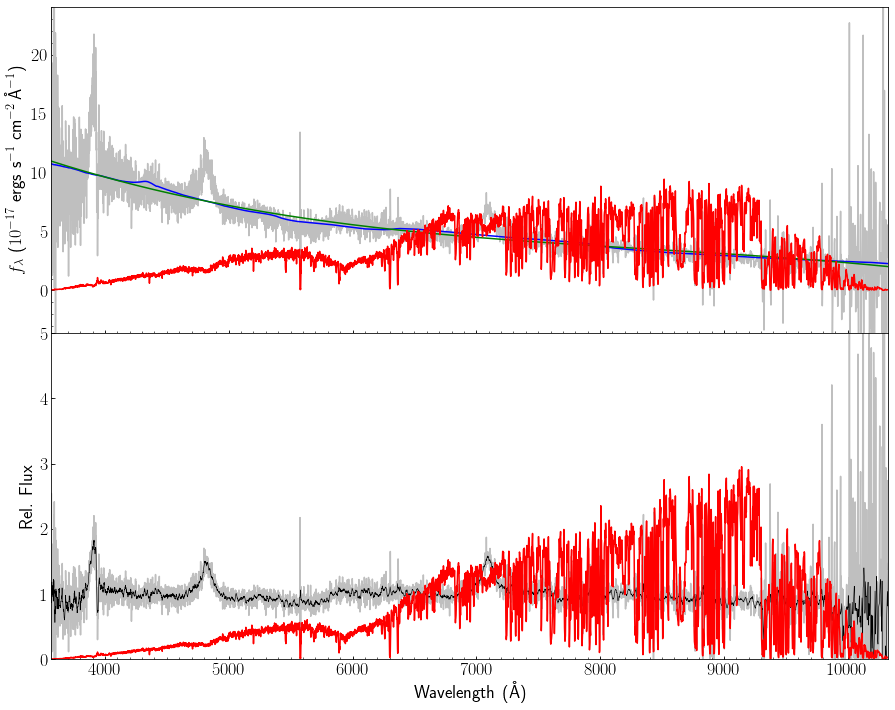

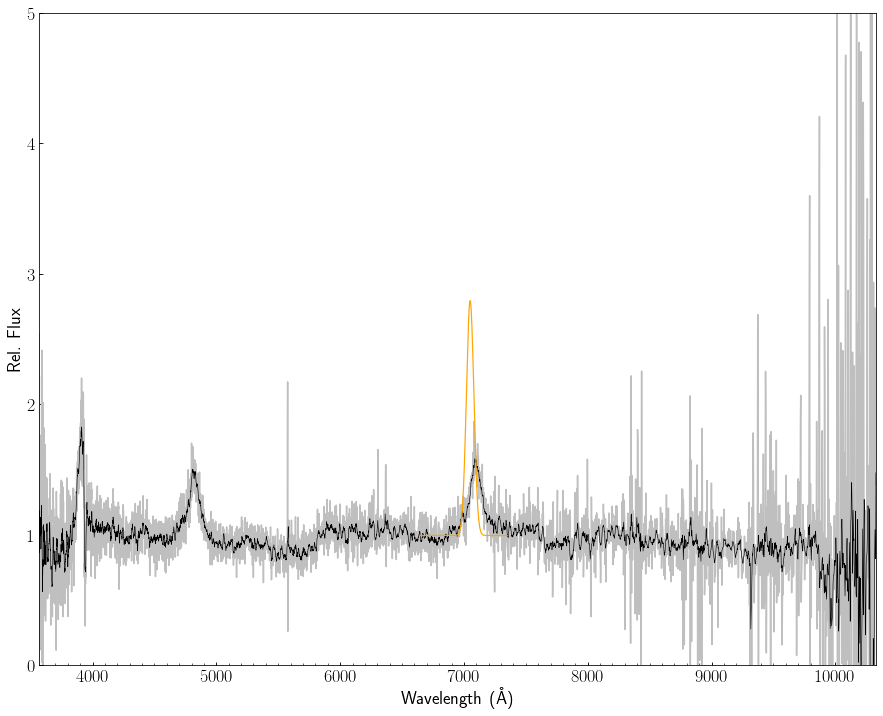

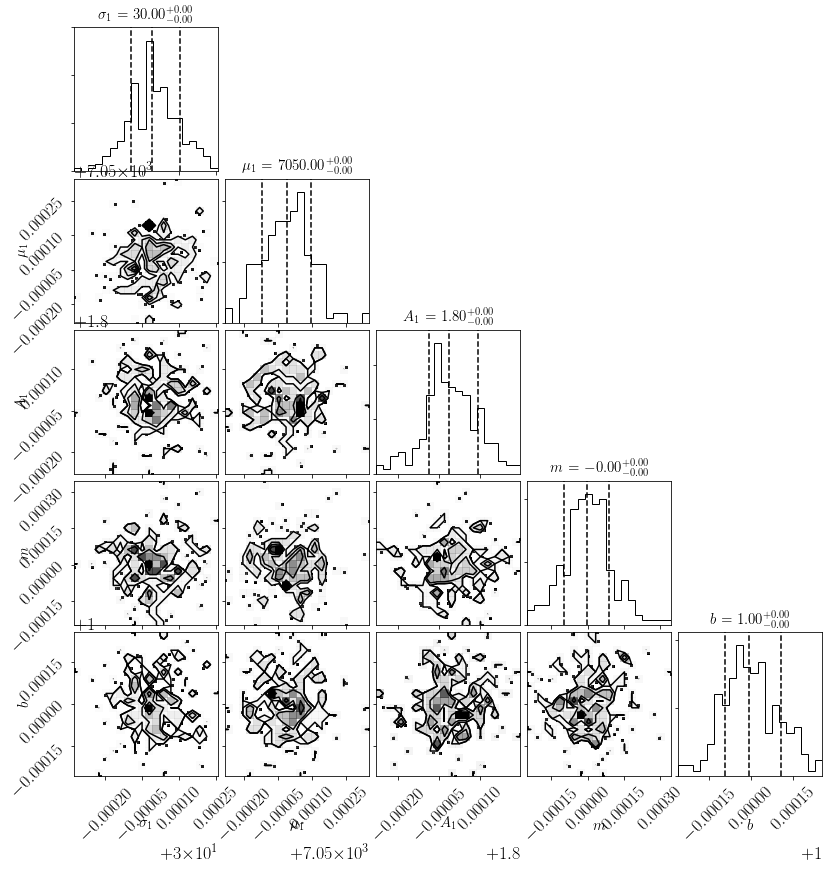

In [98]:
file_load('spec-7294-56739-0021.fits',plot2=True)

### Plotting my Data

After the smoothing I wanted to be able to plot the new data with continuum fit and the smoothed flux values. I copied the file_plot() code from file_load() above and generalized it to work with the new post-smoothing data files. In each plot below the original spectrum is plot in grey in the top plot, with box=1000 smoothing appearing in blue, and the 3rd order legendre fit appearing in green. In the bottom plot, the new spectrum with the continuum divided out is in grey and the box=10 smoothed spectrum appearing in black.

I plot four differen objects to see what they looked like, a star, a galaxy, a QSO, and an "unknown" spectrum.

In [10]:
def file_plot(infile,plot2=True):
    spec_hdr = fits.open(infile)[0].header
    spec_array = fits.open(infile)[1].data
    logwave = spec_array['loglam'] #Wavelength as log10(lambda)
    wave_arr = spec_array['lam'] #Recast the wavelengths in Angstroms
    flux_raw = spec_array['flux_raw'] #Flux at a given wavelength. Units of 10^(-17) erg/s/cm^(2)/Ang
    flux_err = spec_array['ivar']
    zobj = float(spec_hdr['Z_VI'])
    obj_class = int(spec_hdr['OBJ_CLAS'])
    
    #Fit the continuum to a polynomial using Legendre polynomials
    box_continuum = spec_array['cont_flux']
    param_lgd = np.array([float(spec_hdr['LGD_PRM0']),float(spec_hdr['LGD_PRM1']),
                          float(spec_hdr['LGD_PRM2']),float(spec_hdr['LGD_PRM3'])])
    continuum_fit = spec_array['cont_fit'] #continuum fit
    flux_reduced = spec_array['flux_reduced'] #Reduce the flux
    err_reduced = spec_array['err_reduced'] #Reduce the ivar
        
    #Pick out the emission lines
    line_flux,line_err = spec_array['line_flux'],spec_array['line_err']
    
    line_arr = line_load()
    for i in range(len(line_arr)):
        line_arr['OBS_WAVE'][i] = line_arr['REST_WAVE'][i] * (zobj + 1)
    wlines = np.where((line_arr['OBS_WAVE']>=3700)&(line_arr['OBS_WAVE']<=9000))[0]
    vis_lines = line_arr[wlines]
        
    
    x_lower = np.amin(wave_arr)
    x_upper = np.amax(wave_arr)
    vis_range = np.where((wave_arr>=3700)&(wave_arr<=9000))[0]
    y_range = np.amax(flux_raw[vis_range]) - np.amin(flux_raw[vis_range])
    y_pad = float(y_range) / 10
    y_lower = np.amin(flux_raw[vis_range]) - y_pad
    y_upper = np.amax(flux_raw[vis_range]) + y_pad
    
    if plot2==True:
        #Plot some things for analysis
        fig2,ax2 = plt.subplots(nrows=2,ncols=1,figsize=(15,12),sharex='col')
        ax2[0].plot(wave_arr,flux_raw,color='0.75')
        ax2[0].plot(wave_arr,box_continuum,color='blue')
        ax2[0].plot(wave_arr,continuum_fit,color='green')
        #ax2[0].plot(wave_arr,flux_err,color='red')
        ax2[1].plot(wave_arr,flux_reduced,color='0.75')
        ax2[1].plot(wave_arr,line_flux,linewidth=0.6,color='black')
        #ax2[1].plot(wave_arr,err_reduced,color='red')
        ax2[0].set_xlim((x_lower,x_upper))
        ax2[1].set_xlabel(r'Wavelength (\AA)')
        for i in range(2):
            if i < 1:
                ax2[i].set_ylim((y_lower,y_upper))
                ax2[i].set_ylabel(r'$f_{\lambda}$ ($10^{-17}$ ergs s$^{-1}$ cm$^{-2}$\,\AA$^{-1}$)')
            else:
                ax2[i].set_ylim((0,5))
                ax2[i].set_ylabel(r'Rel. Flux')
            ax2[i].tick_params(axis='both',direction='in')
            ax2[i].tick_params(axis='both',which='minor',direction='in')
            ax2[i].xaxis.set_minor_locator(ticker.MultipleLocator(100))
            ax2[i].yaxis.set_minor_locator(ticker.MultipleLocator(1))
        
        fig2.subplots_adjust(wspace=0,hspace=0)

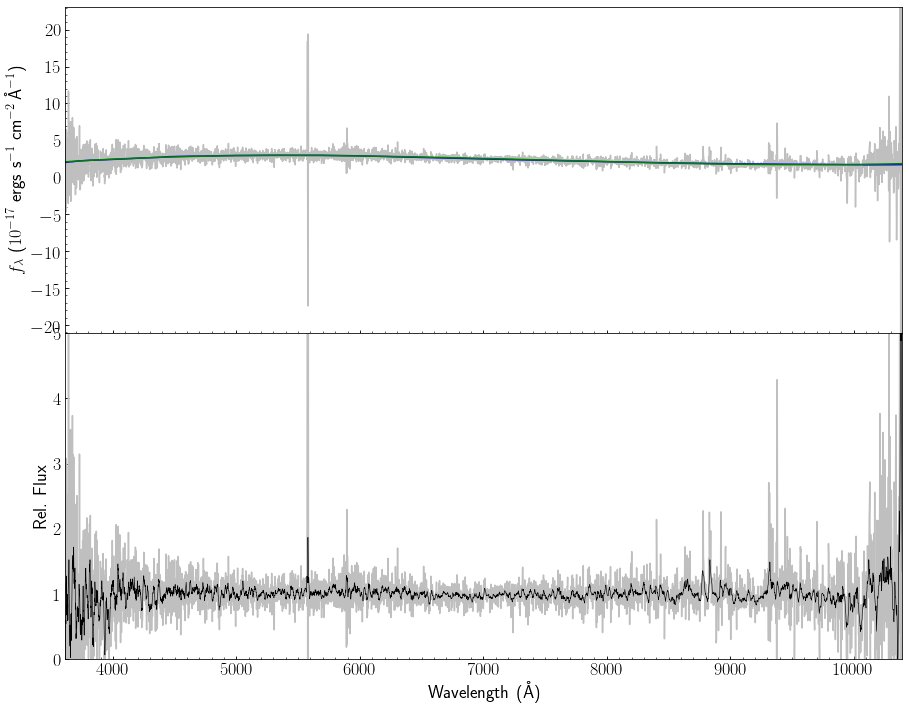

In [77]:
#This is a star smoothed.
file_plot('../ica_spec/7379/spec-7379-56713-0984-reduced.fits',plot2=True)

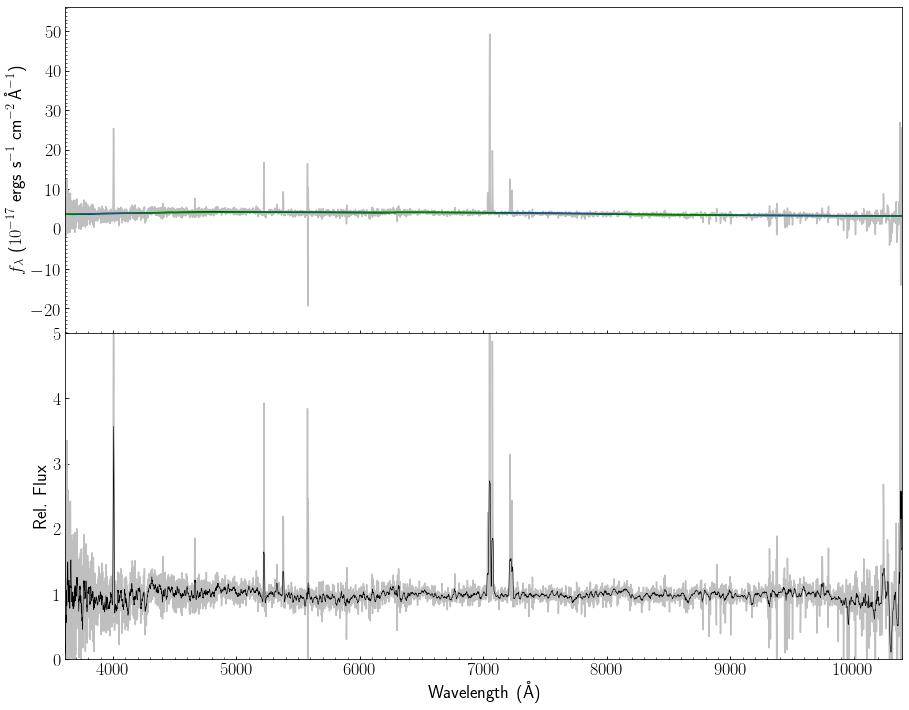

In [78]:
#This is a galaxy smoothed.
file_plot('../ica_spec/7379/spec-7379-56713-0966-reduced.fits',plot2=True)

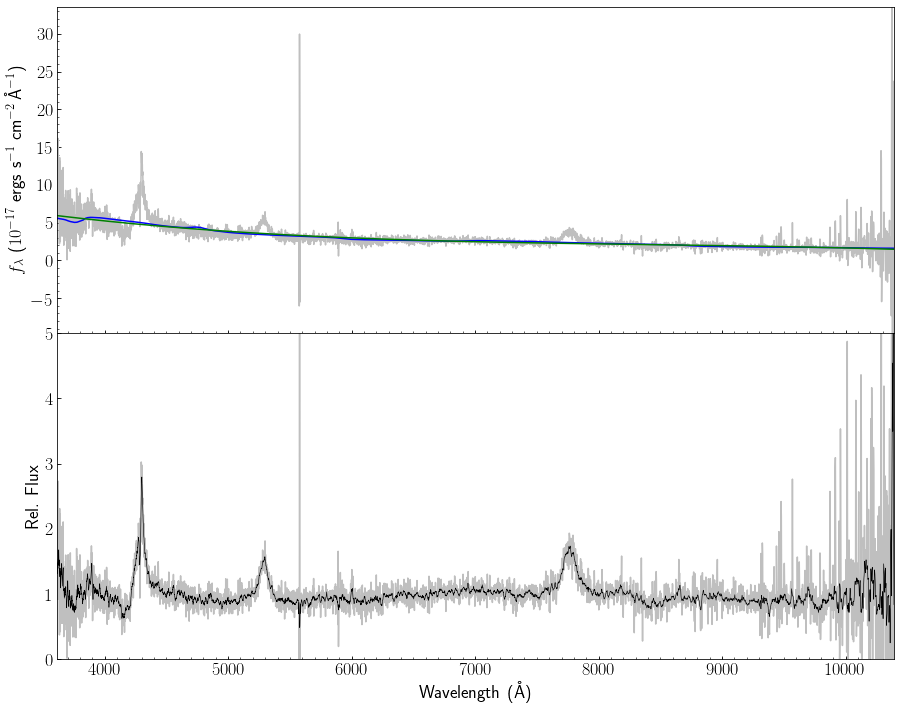

In [81]:
#This is a Broad Absorption Line (BAL) QSO smoothed.
file_plot('../ica_spec/7379/spec-7379-56713-0940-reduced.fits',plot2=True)

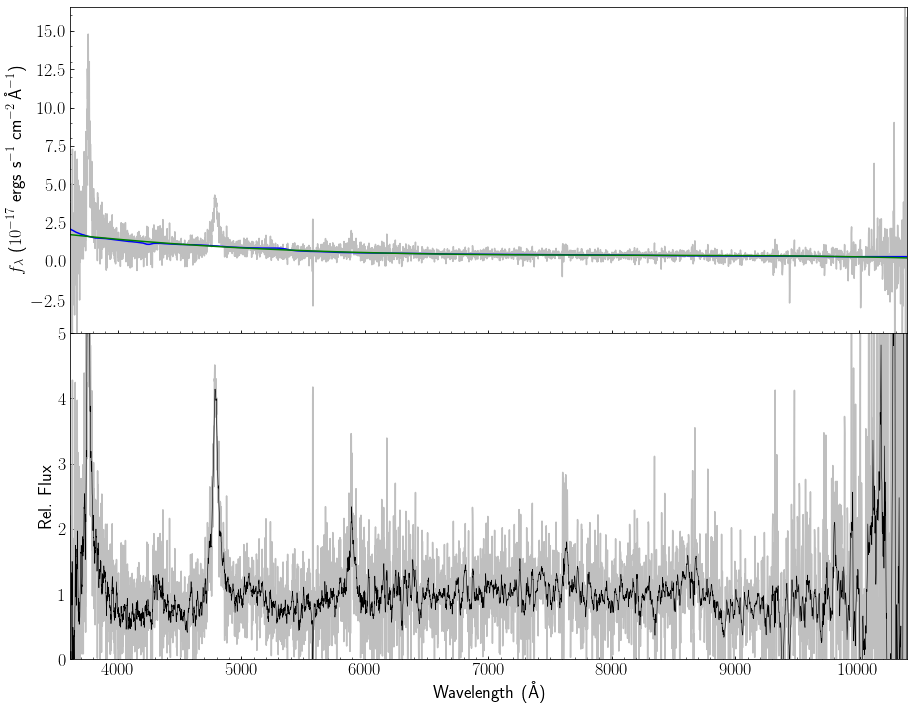

In [84]:
#This is a different QSO smoothed. This is a different spectrum as the test spectrum.
#Notice that the spectrum, even smoothed, is much messier than the test spectrum.
file_plot('../ica_spec/7379/spec-7379-56713-0938-reduced.fits',plot2=True)

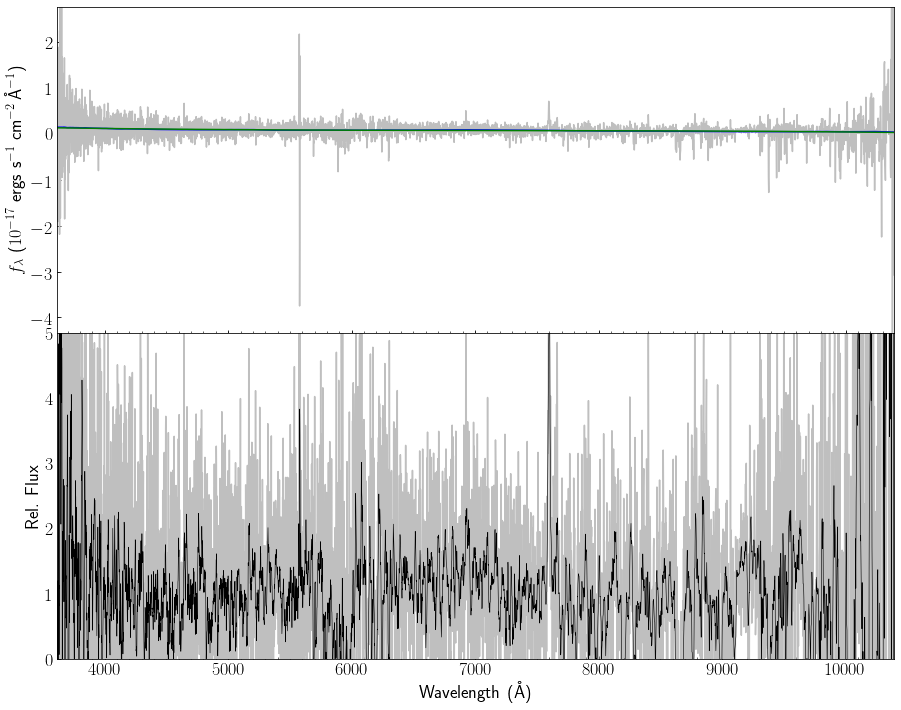

In [79]:
#This is an unknown smoothed.
file_plot('../ica_spec/7379/spec-7379-56713-0953-reduced.fits',plot2=True)

### Fitting the Emission Gaussian

This is the first iteration of just the line fitting. Notice the large number of parameters that have to be passed to the function by hand. I tested this with a single spectrum generating a strong fit (seen in the corner plot below). The number of walkers was far too high (200) and they were all taking far too many steps (1000 burn-in, 4000 after). This was copied originally from another project where I did emission line fitting to a Gaussian. The scope of that project, however, required a strong Gaussian fit. This project, though, only requires a rough fit to make a binary QSO/NotQSO determination. I later changed these emcee parameters to make it run faster.

With this set up processing all of my spectra would have taken seven weeks (~2 min. per spectrum). I got that down, later, to ~7 sec / spectrum. Also note that the hand-passed parameters mean this function fits a specific line, essentially. I needed a function that could fit an arbitrary line pulled from the table (provided by line_load()). That functionality was added in file_autoline().

In [88]:
def file_linefit(infile,lam_lower,lam_upper,g_in,x0_in,A_in,m_in,b_in,cont_pad=150.0):
    #g_lower,g_upper = 10.0,100.0
    #x0_lower,x0_upper = 6800.0,7200.0
    #A_lower,A_upper = -1.0,4.0
    #m_lower,m_upper = -0.5,10.0
    #b_lower,b_upper = -4.0,5.0
    global g_lower,g_upper,x0_lower,x0_upper,A_lower,A_upper,m_lower,m_upper,b_lower,b_upper
    g_lower,g_upper = 10.0,100.0
    A_lower,A_upper = -2.0,6.0
    m_lower,m_upper = -1.0,9.0
    b_lower,b_upper = -5.0,5.0
    x0_lower = lam_lower + cont_pad
    x0_upper = lam_upper - cont_pad
    
    
    spec_array = fits.open(infile)[1].data
    spec_hdr = fits.open(infile)[0].header
    logwave = spec_array['loglam'] #Wavelength as log10(lambda)
    wave_arr = spec_array['lam'] #Recast the wavelengths in Angstroms
    flux_raw = spec_array['flux_raw'] #Flux at a given wavelength. Units of 10^(-17) erg/s/cm^(2)/Ang
    flux_err = spec_array['ivar']
    zobj = float(spec_hdr['Z_VI'])
    obj_class = int(spec_hdr['OBJ_CLAS'])
    
    #Fit the continuum to a polynomial using Legendre polynomials
    box_continuum = spec_array['cont_flux']
    param_lgd = np.array([float(spec_hdr['LGD_PRM0']),float(spec_hdr['LGD_PRM1']),
                          float(spec_hdr['LGD_PRM2']),float(spec_hdr['LGD_PRM3'])])
    continuum_fit = spec_array['cont_fit'] #continuum fit
    flux_reduced = spec_array['flux_reduced'] #Reduce the flux
    err_reduced = spec_array['err_reduced'] #Reduce the ivar
        
    #Pick out the emission lines
    line_flux,line_err = spec_array['line_flux'],spec_array['line_err']
    
    line_arr = line_load()
    for i in range(len(line_arr)):
        line_arr['OBS_WAVE'][i] = line_arr['REST_WAVE'][i] * (zobj + 1)
    wlines = np.where((line_arr['OBS_WAVE']>=3700)&(line_arr['OBS_WAVE']<=9000))[0]
    vis_lines = line_arr[wlines]
        
    
    x_lower = np.amin(wave_arr)
    x_upper = np.amax(wave_arr)
    vis_range = np.where((wave_arr>=3700)&(wave_arr<=9000))[0]
    y_range = np.amax(flux_raw[vis_range]) - np.amin(flux_raw[vis_range])
    y_pad = float(y_range) / 10
    y_lower = np.amin(flux_raw[vis_range]) - y_pad
    y_upper = np.amax(flux_raw[vis_range]) + y_pad
    
    g_true,x0_true,A_true,m_true,b_true = g_in,x0_in,A_in,m_in,b_in
    result = [g_true,x0_true,A_true,m_true,b_true]
    ndim, nwalkers = 5, 200
    p0 = [result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    wem = np.where((wave_arr>=lam_lower)&(wave_arr<=lam_upper))[0]
    x_em = wave_arr[wem]
    y_em = line_flux[wem]
    err_em = line_err[wem]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x_em,y_em,err_em),a=3)
    
    #Burn-in
    pos,prob,state = sampler.run_mcmc(p0, 500) #----Ran well with 500
    sampler.reset()
    pos, prob, state = sampler.run_mcmc(pos, 4000) #----Ran well with 1000
    samples = sampler.flatchain
    g_mcmc, x0_mcmc, A_mcmc, m_mcmc,b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
    acmean = np.mean(sampler.acceptance_fraction)
    print('\n')
    print('----------------PARAMETERS------------------')
    print('Parameter |   50th   |   84th   |   16th   |')
    print('--------------------------------------------')
    print('    g     |  {0:5.2f}   |  {1:5.2f}   | {2:5.2f}    |'.format(g_mcmc[0],g_mcmc[1],g_mcmc[2]))
    print('    x0    |  {0:4d}    |  {1:4d}    | {2:4d}     |'.format(int(x0_mcmc[0]),int(x0_mcmc[1]),int(x0_mcmc[2])))
    print('    A     |  {0:5.2f}   |  {1:5.2f}   | {2:5.2f}    |'.format(A_mcmc[0],A_mcmc[1],A_mcmc[2]))
    print('    m     |  {0:6.2f}  |  {1:6.2f}  | {2:6.2f}   |'.format(m_mcmc[0],m_mcmc[1],m_mcmc[2]))
    print('    b     |  {0:.4f} | {1:0.6f} | {2:0.6f} |'.format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
    print('--------------------------------------------')
    print('Mean Acceptance Fraction: {0:6.4f}'.format(acmean))

    y_lor = line_func(x_em,g_mcmc[0],x0_mcmc[0],A_mcmc[0],m_mcmc[0],b_mcmc[0])
    
    fig1,ax1 = plt.subplots(figsize=(15,12))
    ax1.plot(wave_arr,flux_reduced,color='0.75')
    ax1.plot(wave_arr,line_flux,linewidth=0.6,color='black')
    #ax1.plot(wave_arr,flux_err,linewidth=0.6,color='red')
    ax1.plot(x_em,y_lor,linewidth=1.2,color='orange')
    ax1.set_xlim((x_lower,x_upper))
    ax1.set_xlabel(r'Wavelength (\AA)')
    ax1.set_ylim((0,5))
    ax1.set_ylabel(r'Rel. Flux')
    ax1.tick_params(axis='both',direction='in')
    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(100))
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    
    fig2 = corner.corner(samples[:,:], labels=["$\sigma_1$", "$\mu_1$", "$A_1$","$m$","$b$"],
                      label_kwargs={"fontsize": 15},quantiles=[0.16, 0.5, 0.84],
                      show_titles=True, title_kwargs={"fontsize": 15})
    



----------------PARAMETERS------------------
Parameter |   50th   |   84th   |   16th   |
--------------------------------------------
    g     |  35.96   |   1.43   |  1.40    |
    x0    |  5290    |     1    |    1     |
    A     |   0.53   |   0.01   |  0.01    |
    m     |   -0.00  |    0.00  |   0.00   |
    b     |  2.3617 | 0.208546 | 0.210626 |
--------------------------------------------
Mean Acceptance Fraction: 0.3848


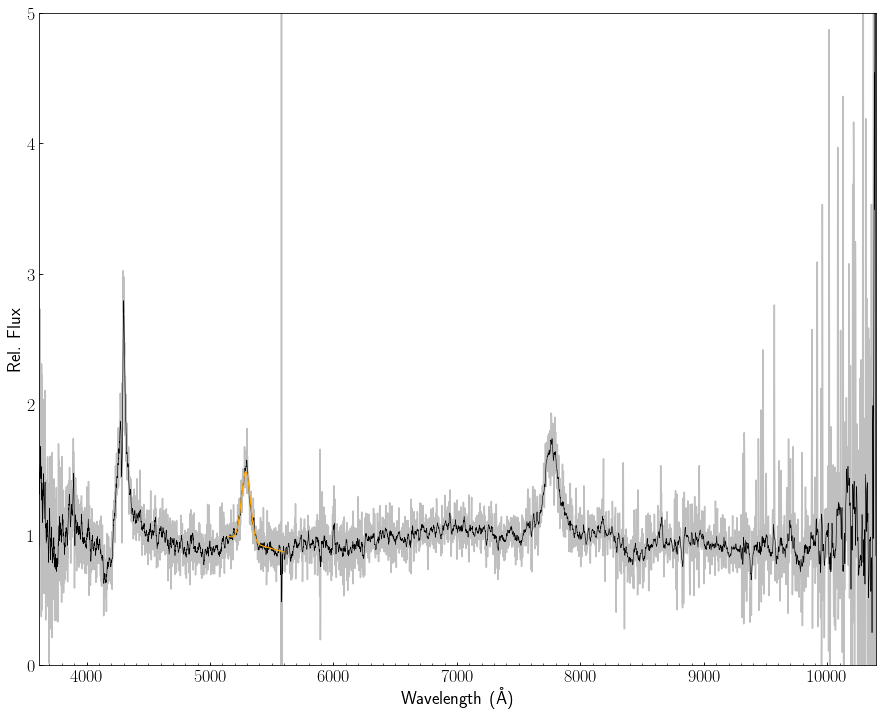

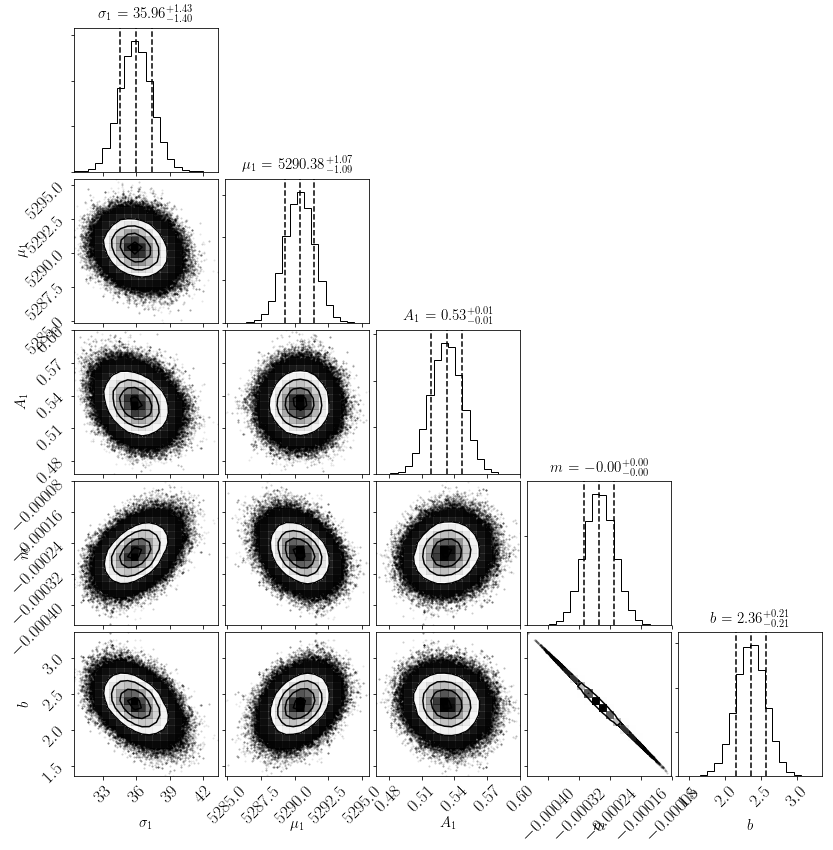

In [89]:
#This is a Broad Absorption Line (BAL) QSO smoothed line fit with mcmc
file_linefit('../ica_spec/7379/spec-7379-56713-0940-reduced.fits',5150.0,5600.0,50,5300.0,1.5,0.0,1.0,cont_pad=30.0)

file_autoline() is the first attempt at the generalized line fitting function. Notice that the number of parameters that have to be fed to the function is now just the name of the file name of the spectrum to be processed. I reduced the number of emcee walkers to 50, reduced the number of steps each takes (100 burn-in, 1000 other). I originally had the function output the table (commented out) for each line to see how it was doing with a star and if it would output a QSO flag. The second run, below, I commented out the table and had it output only the automated class flag and the real class flag.

In [11]:
def file_autoline(infile):
    match_flag = 0
    #g_lower,g_upper = 10.0,100.0
    #x0_lower,x0_upper = 6800.0,7200.0
    #A_lower,A_upper = -1.0,4.0
    #m_lower,m_upper = -0.5,10.0
    #b_lower,b_upper = -4.0,5.0
    global g_lower,g_upper,x0_lower,x0_upper,A_lower,A_upper,m_lower,m_upper,b_lower,b_upper
    g_lower,g_upper = 10.0,100.0
    A_lower,A_upper = -2.0,6.0
    m_lower,m_upper = -1.0,9.0
    b_lower,b_upper = -5.0,5.0
    
    
    spec_array = fits.open(infile)[1].data
    spec_hdr = fits.open(infile)[0].header
    logwave = spec_array['loglam'] #Wavelength as log10(lambda)
    wave_arr = spec_array['lam'] #Recast the wavelengths in Angstroms
    flux_raw = spec_array['flux_raw'] #Flux at a given wavelength. Units of 10^(-17) erg/s/cm^(2)/Ang
    flux_err = spec_array['ivar']
    zobj = float(spec_hdr['Z_VI'])
    obj_class = int(spec_hdr['OBJ_CLAS'])
    if zobj < 0.0:
        zobj = 0.0
    
    #Fit the continuum to a polynomial using Legendre polynomials
    box_continuum = spec_array['cont_flux']
    param_lgd = np.array([float(spec_hdr['LGD_PRM0']),float(spec_hdr['LGD_PRM1']),
                          float(spec_hdr['LGD_PRM2']),float(spec_hdr['LGD_PRM3'])])
    continuum_fit = spec_array['cont_fit'] #continuum fit
    flux_reduced = spec_array['flux_reduced'] #Reduce the flux
    err_reduced = spec_array['err_reduced'] #Reduce the ivar
        
    #Pick out the emission lines
    line_flux,line_err = spec_array['line_flux'],spec_array['line_err']
    
    line_arr = line_load()
    for i in range(len(line_arr)):
        line_arr['OBS_WAVE'][i] = line_arr['REST_WAVE'][i] * (zobj + 1)
    wlines = np.where((line_arr['OBS_WAVE']>=3700)&(line_arr['OBS_WAVE']<=9000))[0]
    vis_lines = line_arr[wlines]
    
    for i in range(len(wlines)):
        lam_center = vis_lines['OBS_WAVE'][i]
        x0_lower = lam_center - 100.0
        x0_upper = lam_center + 100.0
        lam_lower = lam_center - 300.0
        lam_upper = lam_center + 300.0
        g_true,x0_true,A_true,m_true,b_true = 50.0,lam_center,1.5,0.0,1.0
        result = [g_true,x0_true,A_true,m_true,b_true]
        ndim, nwalkers = 5, 50
        p0 = [result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
        wem = np.where((wave_arr>=lam_lower)&(wave_arr<=lam_upper))[0]
        x_em = wave_arr[wem]
        y_em = line_flux[wem]
        err_em = line_err[wem]
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x_em,y_em,err_em),a=3)
    
        #Burn-in
        pos,prob,state = sampler.run_mcmc(p0, 100) #----Ran well with 500
        sampler.reset()
        pos, prob, state = sampler.run_mcmc(pos, 1000) #----Ran well with 1000
        samples = sampler.flatchain
        g_mcmc, x0_mcmc, A_mcmc, m_mcmc,b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                 zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0)))
        acmean = np.mean(sampler.acceptance_fraction)
        '''
        print('\n')
        print('----------------PARAMETERS------------------')
        print('Parameter |   50th   |   84th   |   16th   |')
        print('--------------------------------------------')
        print('    g     |  {0:5.2f}   |  {1:5.2f}   | {2:5.2f}    |'.format(g_mcmc[0],g_mcmc[1],g_mcmc[2]))
        print('    x0    |  {0:4d}    |  {1:4d}    | {2:4d}     |'.format(int(x0_mcmc[0]),int(x0_mcmc[1]),int(x0_mcmc[2])))
        print('    A     |  {0:5.2f}   |  {1:5.2f}   | {2:5.2f}    |'.format(A_mcmc[0],A_mcmc[1],A_mcmc[2]))
        print('    m     |  {0:6.2f}  |  {1:6.2f}  | {2:6.2f}   |'.format(m_mcmc[0],m_mcmc[1],m_mcmc[2]))
        print('    b     |  {0:.4f} | {1:0.6f} | {2:0.6f} |'.format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
        print('--------------------------------------------')
        print('Mean Acceptance Fraction: {0:6.4f}'.format(acmean))
        '''
        #fwhm = 2.355 * g_mcmc[0] #FWHM definition.
        #broad_check = (fwhm / x0_mcmc[0]) * 299792.458 #velocity dispersion in 
        y_lor = line_func(x_em,g_mcmc[0],x0_mcmc[0],A_mcmc[0],m_mcmc[0],b_mcmc[0])
        max_amp = np.amax(y_lor)
        if ((g_mcmc[0]>=20.0)&(g_mcmc[0]<100.0)&(acmean>0.2)&(acmean<0.5)&(max_amp>1.2)):
            match_flag = 1
            #print('\n')
            #print('TARGET IS QSO')
            #print('\n')
            #print('Max. Relative Flux: {0:06.4f}'.format(max_amp))
            break
    return match_flag,obj_class

In [110]:
#This is a STAR smoothed and now fit using autoline.
#Determination of "QSO" status made automatically.
file_autoline('../ica_spec/7379/spec-7379-56713-0984-reduced.fits')



----------------PARAMETERS------------------
Parameter |   50th   |   84th   |   16th   |
--------------------------------------------
    g     |  22.15   |  15.74   |  6.62    |
    x0    |  3798    |     9    |   16     |
    A     |   0.30   |   0.11   |  0.11    |
    m     |    0.00  |    0.00  |   0.00   |
    b     |  -1.0799 | 1.017691 | 1.070724 |
--------------------------------------------
Mean Acceptance Fraction: 0.3177


----------------PARAMETERS------------------
Parameter |   50th   |   84th   |   16th   |
--------------------------------------------
    g     |  90.96   |   6.28   |  9.23    |
    x0    |  4144    |    15    |   16     |
    A     |   0.20   |   0.03   |  0.03    |
    m     |    0.00  |    0.00  |   0.00   |
    b     |  -0.6754 | 0.324821 | 0.330027 |
--------------------------------------------
Mean Acceptance Fraction: 0.3639


----------------PARAMETERS------------------
Parameter |   50th   |   84th   |   16th   |
----------------------------

In [94]:
#This is a Broad Absorption Line (BAL) QSO smoothed and now fit using autoline.
#Determination of "QSO" status made automatically.
file_autoline('../ica_spec/7379/spec-7379-56713-0940-reduced.fits')



----------------PARAMETERS------------------
Parameter |   50th   |   84th   |   16th   |
--------------------------------------------
    g     |  42.00   |   6.58   |  6.11    |
    x0    |  3898    |     4    |    4     |
    A     |   0.23   |   0.02   |  0.02    |
    m     |   -0.00  |    0.00  |   0.00   |
    b     |  3.1254 | 0.213337 | 0.213681 |
--------------------------------------------
Mean Acceptance Fraction: 0.3857


TARGET IS QSO




### Shifting the Spectra

Even with the arbitrary line fitting, the parameter space for each line was too varied. The size of the parameter space and variance is dependent on the cosmological redshift of the object where $\lambda_{\textrm{obs}} = \lambda_{\textrm{rest}} \times (1 + z)$ where z is the redshift. This causes the lines to broaden beyond the QSO's own physical processes which broadens them. To reduce the size of the parameter space the emcee walkers would have to cover, I preprocessed the spectrum by shifting it to the rest frame and then shifted it down from varying about 1 to varying about 0. This allowed emcee to fit the $m$ and $b$ parameters much faster and allowing the function to make a better determination on whether a line was "broad" or not.

The QSO/NotQSO flag was decided by three factors: the breadth of the line, the central peak amplitude, and the mean acceptance fraction of the walkers. If any of these were too low (or too high for acceptance fraction) the line fit was considered "bad" and a determination wasn't made. In addition, since I need only one broad emission line to make the determination, I chose to have the function break its loop once any line was fit. This may have caused the high contamination I saw later. Further testing will allow me to use the presence of more than one line to make a more statistically accurate determination.

In [26]:
#This version of autoline with shift the emission lines to the rest frame based on the
#spectrum's redshift. It also flattens it to zero intercept.
def file_autolineS(infile):
    match_flag = 0
    #g_lower,g_upper = 10.0,100.0
    #x0_lower,x0_upper = 6800.0,7200.0
    #A_lower,A_upper = -1.0,4.0
    #m_lower,m_upper = -0.5,10.0
    #b_lower,b_upper = -4.0,5.0
    global g_lower,g_upper,x0_lower,x0_upper,A_lower,A_upper,m_lower,m_upper,b_lower,b_upper
    g_lower,g_upper = 1.0,50.0
    A_lower,A_upper = -2.0,3.0
    m_lower,m_upper = -1.0,1.0
    b_lower,b_upper = -1.0,1.0
    
    
    spec_array = fits.open(infile)[1].data
    spec_hdr = fits.open(infile)[0].header
    logwave = spec_array['loglam'] #Wavelength as log10(lambda)
    wave_arr = spec_array['lam'] #Recast the wavelengths in Angstroms
    flux_raw = spec_array['flux_raw'] #Flux at a given wavelength. Units of 10^(-17) erg/s/cm^(2)/Ang
    flux_err = spec_array['ivar']
    zobj = float(spec_hdr['Z_VI'])
    obj_class = int(spec_hdr['OBJ_CLAS'])
    if zobj < 0.0:
        zobj = 0.0
    
    wave_shift = wave_arr / (1 + zobj)
    
    #Fit the continuum to a polynomial using Legendre polynomials
    box_continuum = spec_array['cont_flux']
    param_lgd = np.array([float(spec_hdr['LGD_PRM0']),float(spec_hdr['LGD_PRM1']),
                          float(spec_hdr['LGD_PRM2']),float(spec_hdr['LGD_PRM3'])])
    continuum_fit = spec_array['cont_fit'] #continuum fit
    flux_reduced = spec_array['flux_reduced'] #Reduce the flux
    err_reduced = spec_array['err_reduced'] #Reduce the ivar
    
    flux_reducedS = flux_reduced - 1.0
        
    #Pick out the emission lines
    line_flux,line_err = spec_array['line_flux'],spec_array['line_err']
    line_fluxS = line_flux - 1.0 #Flattened down to 0.
    line_errS = line_err - 1.0 #Flattened down to 0.
    
    line_arr = line_load()
    lower_shift = 3700 / (1 + zobj)
    upper_shift = 9500 / (1 + zobj)
    for i in range(len(line_arr)):
        line_arr['OBS_WAVE'][i] = line_arr['REST_WAVE'][i] * (zobj + 1)
    wlines = np.where((line_arr['REST_WAVE']>=lower_shift)&(line_arr['REST_WAVE']<=upper_shift))[0]
    vis_lines = line_arr[wlines]
    
    for i in range(len(wlines)):
        lam_center = vis_lines['REST_WAVE'][i]
        x0_lower = lam_center - 30.0
        x0_upper = lam_center + 30.0
        lam_lower = lam_center - 100.0
        lam_upper = lam_center + 100.0
        g_true,x0_true,A_true,m_true,b_true = 20.0,lam_center,1.5,0.0,0.0
        result = [g_true,x0_true,A_true,m_true,b_true]
        ndim, nwalkers = 5, 50
        p0 = [result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
        wem = np.where((wave_shift>=lam_lower)&(wave_shift<=lam_upper))[0]
        x_em = wave_shift[wem]
        y_em = line_fluxS[wem]
        err_em = line_errS[wem]
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x_em,y_em,err_em),a=3.5)
    
        #Burn-in
        pos,prob,state = sampler.run_mcmc(p0, 100) #----Ran well with 500
        sampler.reset()
        pos, prob, state = sampler.run_mcmc(pos, 1000) #----Ran well with 1000
        samples = sampler.flatchain
        g_mcmc, x0_mcmc, A_mcmc, m_mcmc,b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                 zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0)))
        acmean = np.mean(sampler.acceptance_fraction)
        
        #print('\n')
        #print('Central Wavelength: {0:6.1f}'.format(lam_center))
        #print('----------------PARAMETERS------------------')
        #print('Parameter |   50th   |   84th   |   16th   |')
        #print('--------------------------------------------')
        #print('    g     |  {0:5.2f}   |  {1:5.2f}   | {2:5.2f}    |'.format(g_mcmc[0],g_mcmc[1],g_mcmc[2]))
        #print('    x0    |  {0:4d}    |  {1:4d}    | {2:4d}     |'.format(int(x0_mcmc[0]),int(x0_mcmc[1]),int(x0_mcmc[2])))
        #print('    A     |  {0:5.2f}   |  {1:5.2f}   | {2:5.2f}    |'.format(A_mcmc[0],A_mcmc[1],A_mcmc[2]))
        #print('    m     |  {0:6.2f}  |  {1:6.2f}  | {2:6.2f}   |'.format(m_mcmc[0],m_mcmc[1],m_mcmc[2]))
        #print('    b     |  {0:.4f} | {1:0.6f} | {2:0.6f} |'.format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
        #print('--------------------------------------------')
        #print('Mean Acceptance Fraction: {0:6.4f}'.format(acmean))
        
        #y_lor = line_func(x_em,g_mcmc[0],x0_mcmc[0],A_mcmc[0],m_mcmc[0],b_mcmc[0])
        #max_amp = np.amax(y_lor)
        
        try:
            y_lor = line_func(x_em,g_mcmc[0],x0_mcmc[0],A_mcmc[0],m_mcmc[0],b_mcmc[0])
            max_amp = np.amax(y_lor)
        except Exception:
            continue
        
        #print(max_amp)
        if ((g_mcmc[0]>=5.0)&(g_mcmc[0]<50.0)&(acmean>0.22)&(acmean<0.5)&(max_amp>0.35)):
            match_flag = 1
            #print('\n')
            #print('TARGET IS QSO')
            #print('\n')
            #print('Max. Relative Flux: {0:06.4f}'.format(max_amp))
            break
        '''
        x_lower = np.amin(wave_shift)
        x_upper = np.amax(wave_shift)
        fig1,ax1 = plt.subplots(figsize=(15,12))
        ax1.plot(wave_shift,flux_reducedS,color='0.75')
        ax1.plot(wave_shift,line_fluxS,linewidth=0.6,color='black')
        ax1.plot(x_em,y_lor,linewidth=1.5,color='orange')
        ax1.set_xlim((x_lower,x_upper))
        ax1.set_xlabel(r'Wavelength (\AA)')
        ax1.set_ylim((-2.0,5))
        ax1.set_ylabel(r'Rel. Flux')
        ax1.tick_params(axis='both',direction='in')
        ax1.tick_params(axis='both',which='minor',direction='in')
        ax1.xaxis.set_minor_locator(ticker.MultipleLocator(100))
        ax1.yaxis.set_minor_locator(ticker.MultipleLocator(1))
        
        fig2 = corner.corner(samples[:,:], labels=["$\sigma_1$", "$\mu_1$", "$A_1$","$m$","$b$"],
                          label_kwargs={"fontsize": 15},quantiles=[0.16, 0.5, 0.84],
                          show_titles=True, title_kwargs={"fontsize": 15})
        '''
    return match_flag,obj_class

This is the function call testing. Here 1 means the object is a QSO (as decided by this function) while 3 is the QSO code from the primary file. So, for this spectrum, the function correctly determined this object was a QSO.

In [164]:
file_autolineS('spec-7294-56739-0021-reduced.fits')

(1, 3)

### Running a Plate: Small Scale Testing

The plate_test() function was designed to perform the file_autolineS() classification on all of the files in a single plate. As I had ~37,000 spectra to start with, I chose to store them across 66 subfolders based on their plate number. This also allowed easy testing within a single plate of 607 objects. I chose the 7379 plate as it had all four types of objects I was likely to see. I later found out that it was statistically analogous to the entire data set as the output from this plate's benchmark file was roughly the same as the entire set (as far as average computation time/spectrum time, completeness, and contamination).

This function only runs against a single plate's worth of files. The function after this called plate_run() is the more generalized version (mostly just copied and pasted).

In [28]:
#Larger number test, 7379
import tmark #timer for benchmarking purposes.
import time
def plate_test():
    file_sort = np.sort(glob.glob('../ica_spec/7379/spec*-reduced.fits'))
    num_spectra = len(file_sort)
    bench_array = np.zeros(num_spectra,dtype=[('COMP_TIME','U7'),('PMF','U15'),
                                              ('AUTO_CLASS','U6'),('REAL_CLASS','U6')])
    loop_start = tmark.tm('Starting Class Loop',timer=True)
    benchfile_name = 'benchmark_p7379_w50s.dat'
    bench_file = open(benchfile_name,'w')
    top_line = '#COMPUTATION TIME,PMF LINE,AUTOMATED CLASS,VI CLASS'
    bench_file.write(top_line)
    bench_file.write('\n')
    for i in range(num_spectra):
        class_start = time.time()
        name_temp = file_sort[i]
        plate_temp = int(name_temp[22:26])
        mjd_temp = int(name_temp[27:32])
        fiberid_temp = int(name_temp[33:37])
        pmf_hash = '{0:04d}-{1:05d}-{2:04d}'.format(plate_temp,mjd_temp,fiberid_temp)
        bench_array['PMF'][i] = pmf_hash
        
        aclass_temp,viclass_temp = file_autolineS(name_temp)
        if aclass_temp ==1:
            bench_array['AUTO_CLASS'][i] = 'QSO'
        else:
            bench_array['AUTO_CLASS'][i] = 'NotQSO'
        
        if ((viclass_temp == 3)|(viclass_temp == 30)):
            bench_array['REAL_CLASS'][i] = 'QSO'
        else:
            bench_array['REAL_CLASS'][i] = 'NotQSO'
        
        time_delta = time.time() - class_start
        time_dstr = '{7.3f}'.format
        bench_array['COMP_TIME'][i] = time_dstr
        bench_file_line = '{},{},{},{}'.format(time_delta,pmf_hash,bench_array['AUTO_CLASS'][i],bench_array['REAL_CLASS'][i])
        bench_file.write(bench_file_line)
        bench_file.write('\n')
        pb.pbar(i,num_spectra)
    
    bench_file.close()
    
    loop_end = tmark.tm('Completed Class Loop',timer=True)
    plate_time = loop_end - loop_start
    print('Total Time: {}s'.format(plate_time))

This is the output from a single plate. Note I am still getting "divided by zero" warnings. A note after the plate is from when I finished testing this one plate to see if I would have time to process every good spectrum before the poster was due. I did, with about 3 days to spare.

In [29]:
plate_test()


Starting Class Loop: 2018-04-24 | 11:54:38
Record:    2/ 607 | Percent: [>                                       ]   0%

/usr/local/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
/d/users/blyke/code/my_lib/emcee-2.2.1-py3.6.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
/d/users/blyke/code/my_lib/emcee-2.2.1-py3.6.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
/usr/local/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


Record:  149/ 607 | Percent: [=========>                              ]  24%

/usr/local/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in true_divide
  if sys.path[0] == '':


Record:  607/ 607 | Percent: [=======================================>] 100%
Completed Class Loop: 2018-04-24 | 13:08:19
Total Time: 4420.537620544434s


If this is indicative of all plates, this is 7.3 sec / record (on average). With about 35,000 records, I need ~70 hours. Cutting it close.

### Running the Final Code

These next two functions were written to wrap everything I've done until this point. all_plates() loops through the plate subfolders, calling plate_run() which is a generalizing tweak of the plate_test() function. plate_run() calls file_autolineS() to do the line fitting, which in turn calls the line_load() and emcee functions to test specific lines. Each plate outputs a running plaintext dat file that records computation time per spectrum for benchmarking purposes. This also allowed me to do analysis in the event that it crashed halfway through, or restart the function from where it may fail. As it processed files I ran another program in this repository, bench_test.py, to read the benchmark files it is outputting, continually checking on average computation time and how well its classifying objects.

In [30]:
import tmark #timer for benchmarking purposes.
import time
def plate_run(p_in):    
    files_to_scan = '../ica_spec/{}/spec*-reduced.fits'.format(p_in)
    file_sort = np.sort(glob.glob(files_to_scan))
    num_spectra = len(file_sort)
    bench_array = np.zeros(num_spectra,dtype=[('COMP_TIME','U7'),('PMF','U15'),
                                              ('AUTO_CLASS','U6'),('REAL_CLASS','U6')])
    loop_start = tmark.tm('Starting Class Loop',timer=True)
    benchfile_name = 'benchmark_p{}_w50s.dat'.format(p_in)
    bench_file = open(benchfile_name,'w')
    top_line = '#COMPUTATION TIME,PMF LINE,AUTOMATED CLASS,VI CLASS'
    bench_file.write(top_line)
    bench_file.write('\n')
    for i in range(num_spectra):
        class_start = time.time()
        name_temp = file_sort[i]
        plate_temp = int(name_temp[22:26])
        mjd_temp = int(name_temp[27:32])
        fiberid_temp = int(name_temp[33:37])
        pmf_hash = '{0:04d}-{1:05d}-{2:04d}'.format(plate_temp,mjd_temp,fiberid_temp)
        bench_array['PMF'][i] = pmf_hash
        
        aclass_temp,viclass_temp = file_autolineS(name_temp)
        if aclass_temp ==1:
            bench_array['AUTO_CLASS'][i] = 'QSO'
        else:
            bench_array['AUTO_CLASS'][i] = 'NotQSO'
        
        if ((viclass_temp == 3)|(viclass_temp == 30)):
            bench_array['REAL_CLASS'][i] = 'QSO'
        else:
            bench_array['REAL_CLASS'][i] = 'NotQSO'
        
        time_delta = time.time() - class_start
        time_dstr = '{7.3f}'.format
        bench_array['COMP_TIME'][i] = time_dstr
        bench_file_line = '{},{},{},{}'.format(time_delta,pmf_hash,bench_array['AUTO_CLASS'][i],bench_array['REAL_CLASS'][i])
        bench_file.write(bench_file_line)
        bench_file.write('\n')
        pb.pbar(i,num_spectra)
    
    bench_file.close()
    
    loop_end = tmark.tm('Completed Class Loop',timer=True)
    plate_time = loop_end - loop_start
    print('Total Time: {}s'.format(plate_time))

def all_plates():
    folder_sort = np.sort(glob.glob('../ica_spec/7*'))
    w7379 = np.where(folder_sort == '../ica_spec/7379')[0]
    folder_sort2 = np.delete(folder_sort,w7379) #remove the folder I've already done.
    num_plates = len(folder_sort2)
    for i in range(num_plates):
        plate_temp = int(folder_sort2[i][12:16])
        t_str = '---WORKING PLATE: {}'.format(plate_temp)
        tmark.tm(t_str)
        plate_run(plate_temp)


### The Final Countdown

And here's where the code finally ran.

In [31]:
all_plates()


---WORKING PLATE: 7277: 2018-04-24 | 16:50:07

Starting Class Loop: 2018-04-24 | 16:50:07


/usr/local/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
/d/users/blyke/code/my_lib/emcee-2.2.1-py3.6.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
/d/users/blyke/code/my_lib/emcee-2.2.1-py3.6.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater


Record:    2/ 528 | Percent: [>                                       ]   0%

/usr/local/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


Record:  209/ 528 | Percent: [===============>                        ]  39%

/usr/local/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in true_divide
  if sys.path[0] == '':


Record:  492/ 528 | Percent: [====================================>   ]  93%

/usr/local/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in subtract
  del sys.path[0]


Record:  528/ 528 | Percent: [=======================================>] 100%
Completed Class Loop: 2018-04-24 | 17:53:29
Total Time: 3802.0286016464233s

---WORKING PLATE: 7280: 2018-04-24 | 17:53:29

Starting Class Loop: 2018-04-24 | 17:53:29
Record:  520/ 520 | Percent: [=======================================>] 100%
Completed Class Loop: 2018-04-24 | 18:54:10
Total Time: 3641.000221014023s

---WORKING PLATE: 7282: 2018-04-24 | 18:54:10

Starting Class Loop: 2018-04-24 | 18:54:10
Record:  528/ 528 | Percent: [=======================================>] 100%
Completed Class Loop: 2018-04-24 | 19:55:54
Total Time: 3704.580552816391s

---WORKING PLATE: 7284: 2018-04-24 | 19:55:54

Starting Class Loop: 2018-04-24 | 19:55:54
Record:  583/ 583 | Percent: [=======================================>] 100%
Completed Class Loop: 2018-04-24 | 21:03:26
Total Time: 4051.702014684677s

---WORKING PLATE: 7292: 2018-04-24 | 21:03:26

Starting Class Loop: 2018-04-24 | 21:03:26
Record:  501/ 501 | Percent

Record:  499/ 499 | Percent: [=======================================>] 100%
Completed Class Loop: 2018-04-26 | 04:51:59
Total Time: 3690.1204676628113s

---WORKING PLATE: 7389: 2018-04-26 | 04:51:59

Starting Class Loop: 2018-04-26 | 04:51:59
Record:  469/ 469 | Percent: [=======================================>] 100%
Completed Class Loop: 2018-04-26 | 05:52:42
Total Time: 3642.4615609645844s

---WORKING PLATE: 7391: 2018-04-26 | 05:52:42

Starting Class Loop: 2018-04-26 | 05:52:42
Record:  517/ 517 | Percent: [=======================================>] 100%
Completed Class Loop: 2018-04-26 | 06:53:45
Total Time: 3663.326251268387s

---WORKING PLATE: 7393: 2018-04-26 | 06:53:45

Starting Class Loop: 2018-04-26 | 06:53:45
Record:  566/ 566 | Percent: [=======================================>] 100%
Completed Class Loop: 2018-04-26 | 08:00:28
Total Time: 4002.352469921112s

---WORKING PLATE: 7396: 2018-04-26 | 08:00:28

Starting Class Loop: 2018-04-26 | 08:00:28
Record:  615/ 615 | Percen

### Concluding Remarks

This program, over ~70 hours completed automated classification for all smoothed spectra. The metrics from bench_test.py for this program are primarily average computation time, completion, contamination, percent correct, and percent of QSOs lost.

- Average computation time for true QSOs: 7.361 sec (mean), or 6.902 sec (median)
- Average computation time for NonQSOs: 6.959 sec (mean), or 6.276 sec (median)

Completion is defined as the the number of QSOs correctly identified by this program, $N_{A}$, over the number of true QSOs, $N_{T}$, it processed: $\left( N_{A} / N_{T} \right ) \times 100$. Contamination is defined as the number of QSOs the program identified that were actually not QSOs, $N_{c}$, over the total number of these contanminants plus the number of QSOs correction identified: $\left( N_{c} / (N_{c} + N_{A}) \right) \times 100.$ The percent correct is just the total number of correctly identified objects of any type, $N_{R}$, over the total number of objects it classified, $N_{o}$: $\left( N_{R} / N_{o} \right) \times 100$. Finally, the number of lost QSOs was the number of QSOs identified as NotQSOs, $N_{L}$, over the number total number of true QSOs, $N_{T}$: $\left( N_{L} / N_{T} \right) \times 100$.


- Completion: 77.63%
- Contamination: 3.88%
- Percent Correct: 85.39%
- Percent Lost: 22.37%

The program processed 34,998 objects in total, 20,051 of which were actually QSOs. It misidentified 628 contaminants while identifying 16,194 objects as QSOs (both correctly and incorrectly).

The average computation time for classification (not to mention smoothing) is still too high for large-scale deployment (~2 million objects). In addition, as each object identified by this program will be visually inspected by a person, we would prefer that contamination be reduced as much as possible, even at the expense of completeness.